Exemplo de uma CNN para reconhecer meses do ano. 

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import progressbar

Using TensorFlow backend.
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

Carrega a base de dados. Os arquivos train.txt e test.txt contêm os nomes dos arquivos e os labels das imagens que estão dentro do diretório ./data

Note que as imagens precisam ser normalizadas para a entrada da rede neural. Nesse caso, elas estão sendo normalizadas em 64x64. 


---



In [2]:

train_file = '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/train.txt'
test_file = '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/test.txt'
# input image dimensions
img_rows, img_cols = 64, 64
num_classes = 12


def load_images(image_paths, convert=False):

  x = []
  y = []

  for image_path in progressbar.progressbar(image_paths):
    path, label = image_path.split(' ')
    path= '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/' + path
    
    
    if convert:
      image_pil = Image.open(path).convert('RGB') 
    else:
      image_pil = Image.open(path).convert('L')

    img = np.array(image_pil, dtype=np.uint8)

    x.append(img)
    y.append([int(label)])
    
  x = np.array(x)
  y = np.array(y)

  if np.min(y) != 0: 
    y = y-1

  return x, y
	

def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
  arq = open(train_file, 'r')
  texto = arq.read()
  train_paths = texto.split('\n')
	
  print ('Size : ', size )

  train_paths.remove('') #remove empty lines
  train_paths.sort()

  x_train, y_train = load_images(train_paths, convert)

  arq = open(test_file, 'r')
  texto = arq.read()
  test_paths = texto.split('\n')

  test_paths.remove('') #remove empty lines
  test_paths.sort()
  x_test, y_test = load_images(test_paths, convert)
  
  if resize:
    print ("Resizing images...")
    x_train = resize_data(x_train, size, convert)
    x_test = resize_data(x_test, size, convert)

  if not convert:
    x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
    x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)


  print (np.shape(x_train))
  return (x_train, y_train), (x_test, y_test)

###### Resize data
def resize_data(data, size, convert):

  if convert:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
  else:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1]))

  for i, img in enumerate(data):
    large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
    data_upscaled[i] = large_img

  print (np.shape(data_upscaled))
  return data_upscaled


# rgb
input_shape = (img_rows, img_cols, 3)
(x_train, y_train), (x_test, y_test) = load_dataset(train_file, test_file, resize=True, convert=True, size=(img_rows, img_cols))

### save for the confusion matrix
label = []
for i in range(len(x_test)):
	label.append(y_test[i][0])
	

print ('Normalizing images...')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print ('x_train shape:', x_train.shape)

print (x_train.shape[0], 'train samples')
print (x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



  8% (140 of 1578) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:02

Size :  (64, 64)


100% (1578 of 1578) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Resizing images...
(1578, 64, 64, 3)
(401, 64, 64, 3)
(1578, 64, 64, 3)
Normalizing images...
x_train shape: (1578, 64, 64, 3)
1578 train samples
401 test samples


Treina a rede neural com três camada de convolução.

---



In [3]:
from keras.layers.normalization import BatchNormalization

batch_size = 64
epochs = 110


model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print ('Test loss:', score[0])
print ('Test accuracy:', score[1])

#print model.predict_classes(x_test) #classes predicted
#print model.predict_proba(x_test) #classes probability

pred = []
y_pred = model.predict_classes(x_test)
for i in range(len(x_test)):
	pred.append(y_pred[i])

print(confusion_matrix(label, pred))








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1578 samples, validate on 401 samples
Epoch 1/110
1578/1578 [==============================] - 20s 13ms/step - loss: 2.7188 - acc: 0.3644 - val_loss: 4.3214 - val_acc: 0.4015
Epoch 2/110
1578/1578 [==============================] - 16s 10ms/step - loss: 1.0696 - acc: 0.6990 - val_loss: 1.2315 - val_acc: 0.6733
Epoch 3/110
1578/1578 [==============================] - 18s 11ms/step - loss: 0.5594 - acc: 0.8289 - val_loss: 1.1098 - val_acc: 0.7456
Epoch 4/110
1578/1578 [==============================] - 18s 11ms/step - loss: 0.3136 - acc: 0.9024 - val_loss: 0.7549 - val_acc: 0.7855
Epoch 5/110
1578/1578 [==============================] - 18s 11ms/step - loss: 0.2045 - acc: 0.9278 - val_loss: 1.2160 - val_acc: 0.7506
Epoch 6/110
1578/1578 [=============================

1578/1578 [==============================] - 16s 10ms/step - loss: 0.0251 - acc: 0.9924 - val_loss: 0.7695 - val_acc: 0.8853
Epoch 44/110
1578/1578 [==============================] - 19s 12ms/step - loss: 0.0139 - acc: 0.9962 - val_loss: 0.7357 - val_acc: 0.8653
Epoch 45/110
1578/1578 [==============================] - 18s 11ms/step - loss: 0.0177 - acc: 0.9937 - val_loss: 0.6011 - val_acc: 0.9052
Epoch 46/110
1578/1578 [==============================] - 18s 11ms/step - loss: 0.0035 - acc: 0.9994 - val_loss: 0.5673 - val_acc: 0.9152
Epoch 47/110
1578/1578 [==============================] - 18s 12ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.7641 - val_acc: 0.8753
Epoch 48/110
1578/1578 [==============================] - 18s 12ms/step - loss: 0.0043 - acc: 0.9987 - val_loss: 0.4683 - val_acc: 0.9227
Epoch 49/110
1578/1578 [==============================] - 19s 12ms/step - loss: 0.0035 - acc: 0.9987 - val_loss: 0.8788 - val_acc: 0.8304
Epoch 50/110
1578/1578 [=======================

Epoch 102/110
1578/1578 [==============================] - 15s 9ms/step - loss: 3.0551e-04 - acc: 1.0000 - val_loss: 0.5561 - val_acc: 0.9102
Epoch 103/110
1578/1578 [==============================] - 15s 9ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.6458 - val_acc: 0.9002
Epoch 104/110
1578/1578 [==============================] - 15s 9ms/step - loss: 1.2672e-04 - acc: 1.0000 - val_loss: 0.6283 - val_acc: 0.9102
Epoch 105/110
1578/1578 [==============================] - 15s 9ms/step - loss: 8.8882e-04 - acc: 1.0000 - val_loss: 0.6961 - val_acc: 0.9002
Epoch 106/110
1578/1578 [==============================] - 15s 9ms/step - loss: 1.3740e-04 - acc: 1.0000 - val_loss: 0.6366 - val_acc: 0.9052
Epoch 107/110
1578/1578 [==============================] - 15s 9ms/step - loss: 0.0017 - acc: 0.9994 - val_loss: 0.7828 - val_acc: 0.8953
Epoch 108/110
1578/1578 [==============================] - 15s 9ms/step - loss: 8.8651e-04 - acc: 0.9994 - val_loss: 0.7548 - val_acc: 0.9002
Epoch 109/110


Mostra as imagens com erro.

100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


1
Label: agosto  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/AD1329.jpg


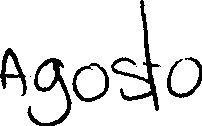

35
Label: fevereiro  | Prediction: janeiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0056.jpg


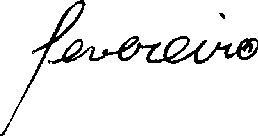

51
Label: abril  | Prediction: agosto /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0119.jpg


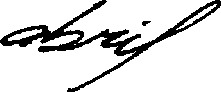

54
Label: maio  | Prediction: abril /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0140.jpg


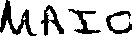

61
Label: setembro  | Prediction: dezembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0247.jpg


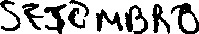

66
Label: setembro  | Prediction: outubro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0253.jpg


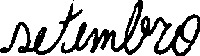

67
Label: setembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0254.jpg


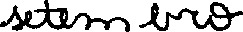

68
Label: setembro  | Prediction: abril /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0255.jpg


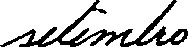

77
Label: setembro  | Prediction: outubro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0265.jpg


81
Label: setembro  | Prediction: dezembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0269.jpg


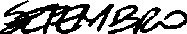

84
Label: setembro  | Prediction: junho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0272.jpg


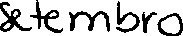

90
Label: outubro  | Prediction: julho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0285.jpg


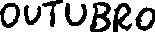

135
Label: novembro  | Prediction: marco /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0331.jpg


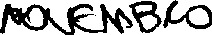

143
Label: dezembro  | Prediction: setembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0339.jpg


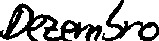

146
Label: dezembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0342.jpg


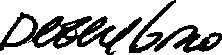

147
Label: dezembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0343.jpg


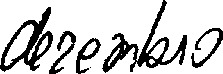

149
Label: dezembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0345.jpg


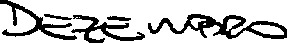

151
Label: dezembro  | Prediction: agosto /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0347.jpg


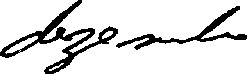

152
Label: dezembro  | Prediction: junho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0348.jpg


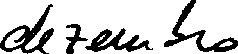

153
Label: dezembro  | Prediction: junho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0349.jpg


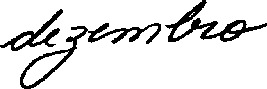

159
Label: dezembro  | Prediction: junho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0355.jpg


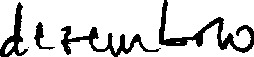

162
Label: dezembro  | Prediction: setembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0358.jpg


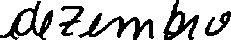

175
Label: janeiro  | Prediction: agosto /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0373.jpg


187
Label: janeiro  | Prediction: fevereiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0385.jpg


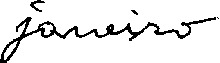

188
Label: janeiro  | Prediction: fevereiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0386.jpg


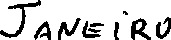

199
Label: fevereiro  | Prediction: outubro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0397.jpg


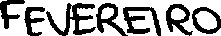

254
Label: marco  | Prediction: maio /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0454.jpg


276
Label: abril  | Prediction: janeiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0476.jpg


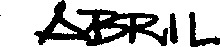

288
Label: maio  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0488.jpg


300
Label: maio  | Prediction: abril /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0500.jpg


314
Label: maio  | Prediction: abril /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0515.jpg


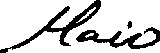

316
Label: junho  | Prediction: julho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0518.jpg


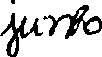

337
Label: junho  | Prediction: janeiro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0539.jpg


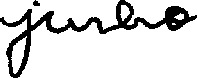

350
Label: julho  | Prediction: junho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0552.jpg


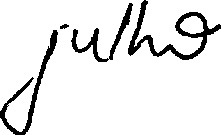

378
Label: agosto  | Prediction: maio /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0597.jpg


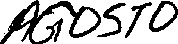

392
Label: dezembro  | Prediction: junho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0700.jpg


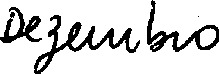

393
Label: dezembro  | Prediction: novembro /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0701.jpg


399
Label: janeiro  | Prediction: julho /home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/td0751.jpg


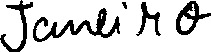

In [33]:
###############################################################################
# Show confusions
###############################################################################
meses = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

from google.colab.patches import cv2_imshow

arq = open(test_file, 'r')
texto = arq.read()
test_paths = texto.split('\n')

test_paths.remove('') #remove empty lines
test_paths.sort()

images =[]
labels = []

for image_path in progressbar.progressbar(test_paths):
  path, label = image_path.split(' ')
  path= '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/' + path
  
  images.append(path)
  labels.append(int(label))
    

for i in range(len(y_pred)):

  ## Erro...
  if (y_pred[i] != labels[i]):
    print (i)
      
    print("Label:", meses[labels[i]], " | Prediction:", meses[y_pred[i]], images[i] )
    im=cv2.imread(images[i])
    cv2_imshow(im)